### Backtest Results: Analysis and Visualization (v2)

This notebook loads the master results file and performs in-depth analysis and visualization, correctly distinguishing between different strategy parameter sets.

**Workflow:**
1.  **Setup:** Configure paths and define the columns that identify a unique strategy.
2.  **Load Data:** Load the master backtest results file.
3.  **Aggregate Analysis:** Calculate performance metrics by grouping on **unique strategy parameters** to ensure a correct, apples-to-apples comparison.
4.  **Visualize Evolving Sharpe:** Plot the evolving Sharpe ratio for the best-performing strategy run.
5.  **Visualize Equity Curve:** Plot the cumulative return (equity curve) for the best-performing strategy run.

### Setup and Configuration

In [29]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np

# --- Project Path Setup ---
NOTEBOOK_DIR = Path.cwd()
ROOT_DIR = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == 'notebooks' else NOTEBOOK_DIR
SRC_DIR = ROOT_DIR / 'src'
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

# --- Local Imports ---
import utils
from config import ANNUAL_RISK_FREE_RATE, TRADING_DAYS_PER_YEAR

# --- Analysis Parameters ---
# ANNUAL_RISK_FREE_RATE = 0.04
# TRADING_DAYS_PER_YEAR = 252
MIN_PERIODS_FOR_SHARPE = 10 

# --- !! CRITICAL: Define columns that identify a unique strategy run !! ---
STRATEGY_ID_COLS = [
    'n_select_requested',
    'filter_min_price',
    'filter_min_avg_volume_m',
    'score_weight_rsi', # Add/remove any parameters you tune
]

# --- File Path Construction ---
BACKTEST_DIR = ROOT_DIR / 'output' / 'backtest_results'
SOURCE_PATH = BACKTEST_DIR / 'backtest_master_results.parquet'

# --- Notebook Setup ---
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1500)
pd.set_option('display.float_format', '{:.4f}'.format)
%load_ext autoreload
%autoreload 2

# --- Verification ---
print(f"Source file for analysis: {SOURCE_PATH}")
print(f"Identifying unique strategies by: {STRATEGY_ID_COLS}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Source file for analysis: c:\Users\ping\Files_win10\python\py311\stocks\output\backtest_results\backtest_master_results.parquet
Identifying unique strategies by: ['n_select_requested', 'filter_min_price', 'filter_min_avg_volume_m', 'score_weight_rsi']


### Step 1: Load Backtest Results

In [30]:
print(f"--- Step 1: Loading data from {SOURCE_PATH.name} ---")

try:
    df_results = pd.read_parquet(SOURCE_PATH)
    # Ensure date column is in datetime format for analysis
    df_results['actual_selection_date_used'] = pd.to_datetime(df_results['actual_selection_date_used'])
    print(f"✅ Successfully loaded and prepared data for {len(df_results)} backtest runs.")
    display(df_results.head())
except FileNotFoundError:
    print(f"❌ ERROR: Source file not found at {SOURCE_PATH}. Halting execution.")
    df_results = None          

--- Step 1: Loading data from backtest_master_results.parquet ---
✅ Successfully loaded and prepared data for 99 backtest runs.


,actual_selection_date_used,average_return,filter_max_debt_eq,filter_min_avg_volume_m,filter_min_price,filter_min_roe_pct,inv_vol_col_name,log_file,n_select_actual,n_select_requested,num_attempted_trades,num_failed_or_skipped_trades,num_selected_tickers,num_successful_trades,portfolio_return,portfolio_return_normalized,run_timestamp,scheme,score_weight_change,score_weight_rel_volume,score_weight_rsi,score_weight_volatility,selection_date,sharpe_ratio_period,std_dev_return,total_weight_traded,win_rate
0,2025-06-11,-0.0178,1.5000,2.0000,10.0000,5.0000,ATR/Price %,backtest_run_20250616_205128.log,10,10,10,0,10,10,-0.0178,-0.0178,2025-06-16 20:51:28,EW,0.3500,0.2000,0.3500,0.1000,2025-06-11,-0.7959,0.0226,1.0000,0.2000
1,2025-06-11,-0.0178,1.5000,2.0000,10.0000,5.0000,ATR/Price %,backtest_run_20250616_205128.log,10,10,10,0,10,10,-0.0172,-0.0172,2025-06-16 20:51:28,IV,0.3500,0.2000,0.3500,0.1000,2025-06-11,-0.7959,0.0226,1.0000,0.2000
2,2025-06-11,-0.0178,1.5000,2.0000,10.0000,5.0000,ATR/Price %,backtest_run_20250616_205128.log,10,10,10,0,10,10,-0.0184,-0.0184,2025-06-16 20:51:28,SW,0.3500,0.2000,0.3500,0.1000,2025-06-11,-0.7959,0.0226,1.0000,0.2000
3,2025-06-10,-0.0016,1.5000,2.0000,10.0000,5.0000,ATR/Price %,backtest_run_20250616_205128.log,10,10,10,0,10,10,-0.0016,-0.0016,2025-06-16 20:51:28,EW,0.3500,0.2000,0.3500,0.1000,2025-06-10,-0.1175,0.0152,1.0000,0.4000
4,2025-06-10,-0.0016,1.5000,2.0000,10.0000,5.0000,ATR/Price %,backtest_run_20250616_205128.log,10,10,10,0,10,10,-0.0014,-0.0014,2025-06-16 20:51:28,IV,0.3500,0.2000,0.3500,0.1000,2025-06-10,-0.1175,0.0152,1.0000,0.4000


In [31]:
print(f'df_results:/n{df_results}')

df_results:/n   actual_selection_date_used  average_return  filter_max_debt_eq  filter_min_avg_volume_m  filter_min_price  filter_min_roe_pct inv_vol_col_name                          log_file  n_select_actual  n_select_requested  num_attempted_trades  num_failed_or_skipped_trades  num_selected_tickers  num_successful_trades  portfolio_return  portfolio_return_normalized       run_timestamp scheme  score_weight_change  score_weight_rel_volume  score_weight_rsi  score_weight_volatility selection_date  sharpe_ratio_period  std_dev_return  total_weight_traded  win_rate
0                  2025-06-11         -0.0178              1.5000                   2.0000           10.0000              5.0000      ATR/Price %  backtest_run_20250616_205128.log               10                  10                    10                             0                    10                     10           -0.0178                      -0.0178 2025-06-16 20:51:28     EW               0.3500                   

In [32]:
print(f'df_results.info():/n{df_results.info()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   actual_selection_date_used    99 non-null     datetime64[ns]
 1   average_return                99 non-null     float64       
 2   filter_max_debt_eq            99 non-null     float64       
 3   filter_min_avg_volume_m       99 non-null     float64       
 4   filter_min_price              99 non-null     float64       
 5   filter_min_roe_pct            99 non-null     float64       
 6   inv_vol_col_name              99 non-null     object        
 7   log_file                      99 non-null     object        
 8   n_select_actual               99 non-null     int64         
 9   n_select_requested            99 non-null     int64         
 10  num_attempted_trades          99 non-null     int64         
 11  num_failed_or_skipped_trades  99 n

### Step 2: Aggregate Performance Analysis (Corrected)

In [33]:
# In py90_backtest_analysis_and_viz_v2.ipynb, replace the "Step 2" cell with this:

if df_results is not None:
    print("\n--- Step 2: Aggregate Performance Analysis (Corrected for 2-Day Cycle) ---")
    
    # This analysis is more complex, so we'll build a list of results
    summary_records = []
    
    # Group by the unique strategy identifiers AND the scheme
    grouped = df_results.groupby(STRATEGY_ID_COLS + ['scheme'])
    
    daily_risk_free_rate = ANNUAL_RISK_FREE_RATE / TRADING_DAYS_PER_YEAR

    print("Analyzing each unique strategy run to account for non-trading 'cash' days...")
    for group_name, group_df in grouped:
        
        # --- 1. Create the correct daily return time series ---
        trade_returns = group_df.set_index(group_df['actual_selection_date_used'] + pd.DateOffset(days=2))['portfolio_return']
        
        start_date = trade_returns.index.min()
        end_date = trade_returns.index.max()
        full_date_range = pd.date_range(start=start_date, end=end_date, freq='B')
        
        daily_return_series = trade_returns.reindex(full_date_range).fillna(0)
        
        # --- 2. Calculate metrics on the CORRECTED time series ---
        mean_return = daily_return_series.mean()
        std_dev_return = daily_return_series.std()
        
        # --- FIX STARTS HERE ---
        # Handle division by zero before calculating Sharpe
        if std_dev_return > 1e-9: # Check if std dev is not effectively zero
            sharpe_ratio = (mean_return - daily_risk_free_rate) / std_dev_return
        else:
            sharpe_ratio = np.nan # Assign NaN if there's no volatility
            
        annualized_sharpe = sharpe_ratio * np.sqrt(TRADING_DAYS_PER_YEAR)
        # --- FIX ENDS HERE ---
        
        # --- 3. Store the results ---
        record = dict(zip(STRATEGY_ID_COLS + ['scheme'], group_name))
        record['Num Trade Days'] = len(group_df)
        record['Total Time Span (B-Days)'] = len(daily_return_series)
        record['Mean Daily Return (adj. for cash)'] = mean_return
        record['Annualized Sharpe Ratio (adj. for cash)'] = annualized_sharpe
        summary_records.append(record)

    # --- 4. Create and display the final summary DataFrame ---
    df_summary = pd.DataFrame(summary_records).set_index(STRATEGY_ID_COLS + ['scheme'])
    df_summary = df_summary.sort_values(by='Annualized Sharpe Ratio (adj. for cash)', ascending=False)
    
    print(f"\nAnalysis complete. Summary based on {TRADING_DAYS_PER_YEAR} trading days/year and {ANNUAL_RISK_FREE_RATE:.2%} annual risk-free rate.")
    print("NOTE: Sharpe Ratios are now correctly adjusted for the 2-day trade cycle (50% cash holding).")
    display(df_summary)

else:
    print("Skipping analysis because data failed to load.")


--- Step 2: Aggregate Performance Analysis (Corrected for 2-Day Cycle) ---
Analyzing each unique strategy run to account for non-trading 'cash' days...

Analysis complete. Summary based on 252 trading days/year and 4.00% annual risk-free rate.
NOTE: Sharpe Ratios are now correctly adjusted for the 2-day trade cycle (50% cash holding).


Num Trade Days  Total Time Span (B-Days)  Mean Daily Return (adj. for cash)  Annualized Sharpe Ratio (adj. for cash)
n_select_requested filter_min_price filter_min_avg_volume_m score_weight_rsi scheme                                                                                                                      
10                 10.0000          2.0000                  0.3500           IV                  33                        35                             0.0013                                   1.8950
                                                                             EW                  33                        35                             0.0008                                   1.0247
                                                                             SW                  33                        35                            -0.0000                                  -0.2238

In [34]:
# # In py90_backtest_analysis_and_viz_v2.ipynb, replace the "Step 2" cell with this:

# if df_results is not None:
#     print("\n--- Step 2: Aggregate Performance Analysis (Corrected for 2-Day Cycle) ---")
    
#     # This analysis is more complex, so we'll build a list of results
#     summary_records = []
    
#     # Group by the unique strategy identifiers AND the scheme
#     grouped = df_results.groupby(STRATEGY_ID_COLS + ['scheme'])
    
#     daily_risk_free_rate = ANNUAL_RISK_FREE_RATE / TRADING_DAYS_PER_YEAR

#     print("Analyzing each unique strategy run to account for non-trading 'cash' days...")
#     for group_name, group_df in grouped:
        
#         # --- 1. Create the correct daily return time series ---
#         # Get the returns and use the SELL date as the index, as the return is realized at the close of the sell day.
#         # Our backtester uses 'actual_selection_date_used', so sell_date is T+2.
#         trade_returns = group_df.set_index(group_df['actual_selection_date_used'] + pd.DateOffset(days=2))['portfolio_return']

#         # Create a full business-day date range for the entire period of the strategy run
#         start_date = trade_returns.index.min()
#         end_date = trade_returns.index.max()
#         full_date_range = pd.date_range(start=start_date, end=end_date, freq='B')
        
#         # Reindex the returns to the full date range. Non-trade days will become NaN.
#         # Fill these non-trade "cash" days with a return of 0.
#         daily_return_series = trade_returns.reindex(full_date_range).fillna(0)
        
#         # --- 2. Calculate metrics on the CORRECTED time series ---
#         mean_return = daily_return_series.mean()
#         std_dev_return = daily_return_series.std()
        
#         # Calculate Sharpe and Annualized Sharpe
#         sharpe_ratio = (mean_return - daily_risk_free_rate) / std_dev_return.replace(0, np.nan)
#         annualized_sharpe = sharpe_ratio * np.sqrt(TRADING_DAYS_PER_YEAR)
        
#         # Store the results
#         # The group_name is a tuple of the strategy parameters
#         record = dict(zip(STRATEGY_ID_COLS + ['scheme'], group_name))
#         record['Num Trade Days'] = len(group_df)
#         record['Total Time Span (B-Days)'] = len(daily_return_series)
#         record['Mean Daily Return (adj. for cash)'] = mean_return
#         record['Annualized Sharpe Ratio (adj. for cash)'] = annualized_sharpe
#         summary_records.append(record)

#     # --- 3. Create and display the final summary DataFrame ---
#     df_summary = pd.DataFrame(summary_records).set_index(STRATEGY_ID_COLS + ['scheme'])
#     df_summary = df_summary.sort_values(by='Annualized Sharpe Ratio (adj. for cash)', ascending=False)
    
#     print(f"\nAnalysis complete. Summary based on {TRADING_DAYS_PER_YEAR} trading days/year and {ANNUAL_RISK_FREE_RATE:.2%} annual risk-free rate.")
#     print("NOTE: Sharpe Ratios are now correctly adjusted for the 2-day trade cycle (50% cash holding).")
#     display(df_summary)

# else:
#     print("Skipping analysis because data failed to load.")

In [35]:
# if df_results is not None:
#     print("\n--- Step 2: Calculating Aggregate Performance per Unique Strategy ---")
    
#     # Group by the unique strategy identifiers AND the scheme
#     grouped = df_results.groupby(STRATEGY_ID_COLS + ['scheme'])['portfolio_return']
    
#     # Calculate aggregate metrics
#     run_counts = grouped.count()
#     mean_return = grouped.mean()
#     std_dev_return = grouped.std()
    
#     daily_risk_free_rate = ANNUAL_RISK_FREE_RATE / TRADING_DAYS_PER_YEAR
    
#     # Calculate Sharpe and Annualized Sharpe
#     sharpe_ratio = (mean_return - daily_risk_free_rate) / std_dev_return.replace(0, np.nan)
#     annualized_sharpe = sharpe_ratio * np.sqrt(TRADING_DAYS_PER_YEAR)
    
#     # Combine into a summary DataFrame
#     df_summary = pd.DataFrame({
#         'Num Days': run_counts,
#         'Mean Daily Return': mean_return,
#         'Annualized Sharpe Ratio': annualized_sharpe
#     }).sort_values(by='Annualized Sharpe Ratio', ascending=False)
    
#     print(f"Analysis of distinct strategy runs, sorted by best Sharpe Ratio:")
#     display(df_summary)
# else:
#     print("Skipping analysis because data failed to load.")

In [36]:
print(f'grouped:/n{grouped}')

grouped:/n<pandas.core.groupby.generic.DataFrameGroupBy object at 0x000001FC0B317FD0>


#######################

In [37]:
STRATEGY_ID_COLS + ['scheme']

['n_select_requested',
 'filter_min_price',
 'filter_min_avg_volume_m',
 'score_weight_rsi',
 'scheme']

In [41]:
# Select the 'portfolio_return' column FIRST, then apply aggregations
df_summary = grouped['portfolio_return'].agg(['mean', 'std', 'count']).sort_values(by='mean', ascending=False)

print("Aggregate statistics for each unique strategy run:")
display(df_summary)

Aggregate statistics for each unique strategy run:


mean    std  count
n_select_requested filter_min_price filter_min_avg_volume_m score_weight_rsi scheme                     
10                 10.0000          2.0000                  0.3500           IV     0.0026 0.0120     33
                                                                             EW     0.0025 0.0134     33
                                                                             SW     0.0020 0.0153     33

In [42]:
# Tell the aggregation functions to automatically ignore non-numeric columns
df_summary_all_numeric = grouped.agg(
    mean=('portfolio_return', lambda x: x.mean(numeric_only=True)),
    std=('portfolio_return', lambda x: x.std(numeric_only=True)),
    count=('portfolio_return', 'count')
).sort_values(by='mean', ascending=False)


# A simpler way if you just want to run the functions on all applicable columns
df_summary_all_numeric = grouped.mean(numeric_only=True)

print("Mean of all numeric columns for each unique strategy run:")
display(df_summary_all_numeric)

Mean of all numeric columns for each unique strategy run:


average_return  filter_max_debt_eq  filter_min_roe_pct  n_select_actual  num_attempted_trades  num_failed_or_skipped_trades  num_selected_tickers  num_successful_trades  portfolio_return  portfolio_return_normalized  score_weight_change  score_weight_rel_volume  score_weight_volatility  sharpe_ratio_period  std_dev_return  total_weight_traded  win_rate
n_select_requested filter_min_price filter_min_avg_volume_m score_weight_rsi scheme                                                                                                                                                                                                                                                                                                                                                                    
10                 10.0000          2.0000                  0.3500           EW              0.0025              1.5000              5.0000          10.0000                9.9697                        0.0303               10.0000                 9.9697            0.0025                       0.0025               0.3500                   0.2000                   0.1000               0.1059          0.0196               0.9970    0.5286
                                                                             IV              0.0025              1.5000              5.0000          10.0000                9.9697                        0.0303               10.0000                 9.9697            0.0026                       0.0026               0.3500                   0.2000                   0.1000               0.1059          0.0196               0.9967    0.5286
                                                                             SW              0.0025              1.5000              5.0000          10.0000                9.9697                        0.0303               10.0000                 9.9697            0.0020                       0.0019               0.3500                   0.2000                   0.1000               0.1059          0.0196               0.9955    0.5286

In [38]:
# To inspect the results of your groupby operation, apply aggregations:
df_summary = grouped.agg(['mean', 'std', 'count']).sort_values(by='mean', ascending=False)

print("Aggregate statistics for each unique strategy run:")
display(df_summary)

TypeError: agg function failed [how->mean,dtype->object]

In [ ]:
# Create a summary DataFrame with multiple statistics for each group
df_group_summary = grouped.agg(['mean', 'std', 'count', 'sum', 'min', 'max'])

print("--- Summary Statistics for Each Group ---")
display(df_group_summary)

In [ ]:
# See the names of all the groups pandas created
print("Available group names:")
print(list(grouped.groups.keys())[0:5]) # Print the first 5 group names

# Now, pick one of those names to inspect
# The name will be a tuple, e.g., (10, 10.0, 2.0, 0.35, 'EW')
a_specific_group_name = list(grouped.groups.keys())[0] 

print(f"\n--- Data for the specific group: {a_specific_group_name} ---")
display(grouped.get_group(a_specific_group_name))

#######################

### Step 3: Visualize Evolving Sharpe for Top Strategy


--- Step 3: Plotting Evolving Sharpe Ratio for the Top Strategy Run ---


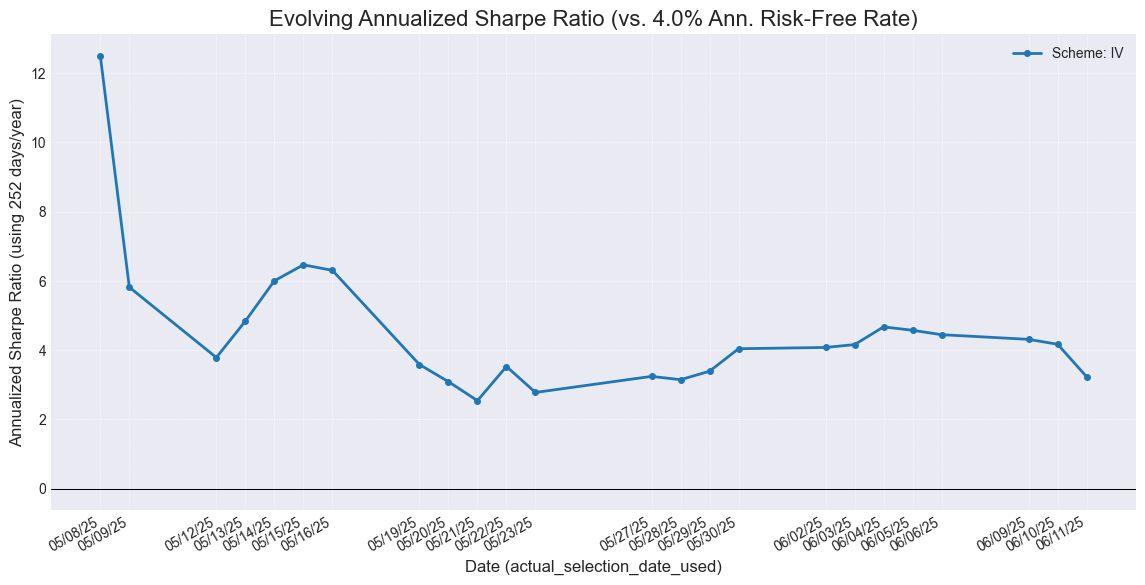

In [39]:
if 'df_summary' in locals() and not df_summary.empty:
    print("\n--- Step 3: Plotting Evolving Sharpe Ratio for the Top Strategy Run ---")
    
    # Get the parameters of the best strategy from our summary table
    top_strategy_params = df_summary.index[0]
    
    # Create a filter mask to select only the data for this specific run
    strategy_filter_mask = (df_results[STRATEGY_ID_COLS + ['scheme']] == top_strategy_params).all(axis=1)
    df_top_strategy = df_results[strategy_filter_mask]

    # Call the utility function
    utils.plot_evolving_annualized_sharpe(
        df=df_top_strategy, # Pass only the filtered data for the best strategy
        date_col='actual_selection_date_used',
        return_col='portfolio_return',
        scheme_col='scheme',
        annual_risk_free_rate=ANNUAL_RISK_FREE_RATE,
        trading_days_per_year=TRADING_DAYS_PER_YEAR,
        min_periods_for_sharpe=MIN_PERIODS_FOR_SHARPE
    )
else:
    print("Skipping visualization.")

### Step 4: Visualize Equity Curve for Top Strategy


--- Step 4: Plotting Cumulative Return (Equity Curve) for Top Strategies ---


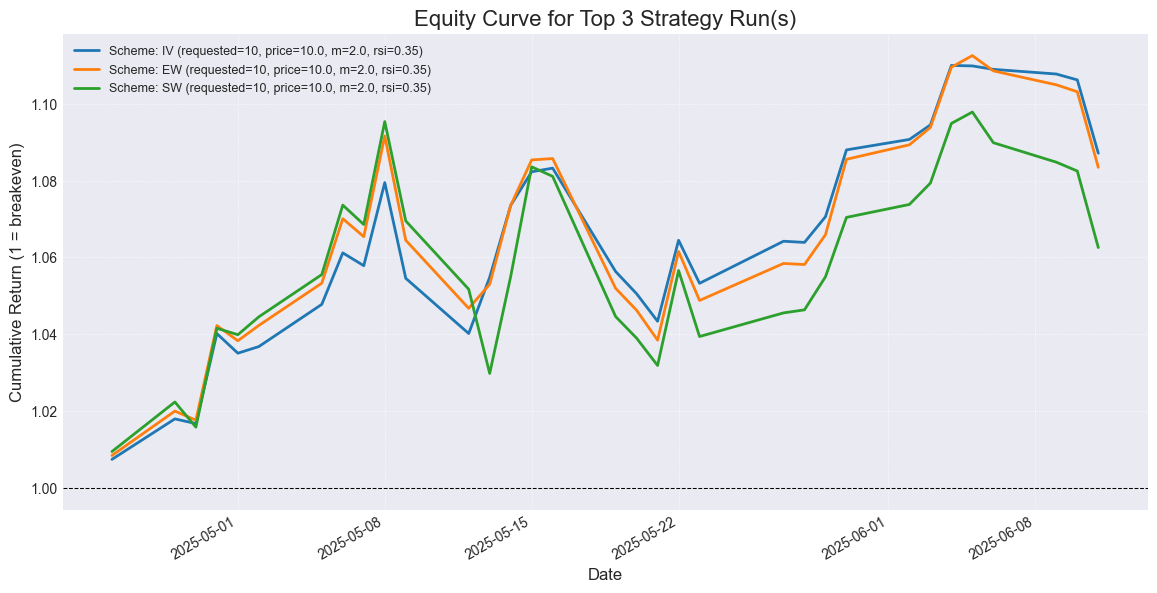

In [40]:
if 'df_summary' in locals() and not df_summary.empty:
    print("\n--- Step 4: Plotting Cumulative Return (Equity Curve) for Top Strategies ---")
    
    # Call our new utility function
    utils.plot_cumulative_returns(
        df=df_results,
        date_col='actual_selection_date_used',
        return_col='portfolio_return',
        scheme_col='scheme',
        strategy_id_cols=STRATEGY_ID_COLS,
        top_n_strategies=3 # Plot the top 3 best runs
    )
else:
    print("Skipping visualization.")